# Team Recommendation System

 This mini-project aims to create a team Recommendation system from a pool of candidates based on the avaialable data. The data will contain the skill level of each candidate on multiple features and the system will generate even teams consisting of these candidates.

## The Approach

The solution provided from this implementation uses clustering algorithm to group similar candidates together and then form a team by picking a candidate from each of these clusters. This way all the teams formed will be balanced as the each of its members belong to a unique cluster and the number of members from each cluster is same in all of the teams.

### Assumption

Let the totol number of candates be $N$. The total number of team be $T$.
Therfore, the number of members per team will be $K = \frac{N}{T}$

We assume that the number of players is perfeclty divisible by the total number of teams. In other words, it is possible to form teams of equal size from the given data.

## $K$ - means clustering algorithm

To cluster our candidates we use the $K$ means clustering algorithm. Here, $K$, the number of centers in our output, is the number of members per each team.

### Dataset

We use the open-source [_IRIS_](https://archive.ics.uci.edu/ml/datasets/iris) dataset. This is a multivariate_(multiple features in our case)_ dataset with a 150 isntances_(candidates in our case)_ and 4 attribute_(number of multivariate attributes)_.

### Importing the libraries

In [642]:
import math;
import sys;
from random import shuffle, uniform, choice;
import numpy as np;
from matplotlib import pyplot;

### Reading the data from file and processing the data

In [643]:
def ReadData(fileName):
    f = open(fileName, 'r');    # declaring pointer to file
    lines = f.read().splitlines();  #reading data from file and splitting it by new lines
    f.close();  # closing the file pointer

    items = []

    for i in range(1,len(lines)):
        line = lines[i].split(','); # split each line by ","
        itemFeatures = [];

        for j in range(len(line)-1):
            v = float(line[j]); #Convert feature value to float
            itemFeatures.append(v); #Add feature value to dict
    
        items.append(itemFeatures);

    shuffle(items);

    return items;

### Auxiliary Function

In [644]:
def FindColMinMax(items):
    n = len(items[0]);
    minima = [sys.maxsize for i in range(n)];
    maxima = [-sys.maxsize -1 for i in range(n)];
    
    for item in items:
        for f in range(len(item)):
            if(item[f] < minima[f]):
                minima[f] = item[f];
            
            if(item[f] > maxima[f]):
                maxima[f] = item[f];

    return minima,maxima;

### Get Euclidean Distance between two points

In [645]:
def EuclideanDistance(x,y):
    S = 0; #The sum of the squared differences of the elements
    for i in range(len(x)):     # through all the dimesion of x and y
        S += math.pow(x[i]-y[i],2);

    return math.sqrt(S); #The square root of the sum

### Initialize Mean
Initialize the Mean of each cluster randomly between the _min_ and _max_ of each feature(here: column)

In [646]:
def InitializeMeans(items, k, cMin, cMax):
    f = len(items[0]); #number of features
    means = [[0 for i in range(f)] for j in range(k)];
    
    for mean in means:
        for i in range(len(mean)):
            #Set value to a random float
            #(adding +-1 to avoid a wide placement of a mean)
            mean[i] = uniform(cMin[i]+1,cMax[i]-1);

    return means;

### Update Mean
Update the mean with each iteration

In [647]:
def UpdateMean(n,mean,item):
    for i in range(len(mean)):
        m = mean[i];
        m = (m*(n-1)+item[i])/float(n);
        mean[i] = round(m,3);
    
    return mean;

### Classify Item

Given all the means and given item, we will find the cluster matching closest to the given item by calculating the Eucledean distance between each mean and the item.

In [648]:
def Classify(means,item):
    #Classify item to the mean with minimum distance
    
    minimum = sys.maxsize;
    index = -1;

    for i in range(len(means)):
        #Find distance from item to mean
        dis = EuclideanDistance(item,means[i]);

        if(dis < minimum):
            minimum = dis;
            index = i;
    
    return index;

### Find Cluster

Find suitable cluster for all the items by iterating through each one of them and classifying them into suitable cluster.

In [649]:
def FindClusters(means,items):
    clusters = [[] for i in range(len(means))]; #Init clusters
    
    for item in items:
        #Classify item into a cluster
        index = Classify(means,item);

        #Add item to cluster
        clusters[index].append(item);

    return clusters;

In [650]:
def FindClustersIndex(means,items):
    clustersIndex = [[] for i in range(len(means))]; #Init clusters
    
    i = 0
    for item in items:
        #Classify item into a cluster
        index = Classify(means,item);

        #Add item to cluster
        clustersIndex[index].append(i);
        i = i + 1;

    return clustersIndex;

### Calculate Means

To get the fine-tuned _means_, iterete through all the items, find the closest cluster and update the cluster's mean.

Repeat this process for fixed number of iterations. If between 2 iterations, no item changes its classification, we stop the process as we have found the optimal classification.

In [651]:
def CalculateMeans(k,items,maxIterations=100000):
    #Find the minima and maxima for columns
    cMin, cMax = FindColMinMax(items);
    
    #Initialize means at random points
    means = InitializeMeans(items,k,cMin,cMax);
    
    #Initialize clusters, the array to hold
    #the number of items in a class
    clusterSizes = [0 for i in range(len(means))];

    #An array to hold the cluster an item is in
    belongsTo = [0 for i in range(len(items))];
    

    #Calculate means
    for e in range(maxIterations):
        #If no change of cluster occurs, halt
        noChange = True;
        for i in range(len(items)):
            item = items[i];
            #Classify item into a cluster and update the
            #corresponding means.
        
            index = Classify(means,item);

            clusterSizes[index] += 1;
            means[index] = UpdateMean(clusterSizes[index],means[index],item);

            #Item changed cluster
            if(index != belongsTo[i]):
                noChange = False;

            belongsTo[i] = index;

        #Nothing changed, return
        if(noChange):
            break;

    return means;

### Functions to plot the data

Cut down the data into 2 dimensions so that we can plot it and percieve it easily and the plot the clusters.

In [652]:
def CutToTwoFeatures(items,indexA,indexB):
    n = len(items);
    X = [];
    for i in range(n):
        item = items[i];
        newItem = [item[indexA],item[indexB]];
        X.append(newItem);

    return X;

In [653]:
def PlotClusters(clusters):
    n = len(clusters);
    #Cut down the items to two dimension and store to X
    X = [[] for i in range(n)];

    for i in range(n):
        cluster = clusters[i];
        print(len(cluster))
        for item in cluster:
            X[i].append(item);

    colors = ['r','b','g','c','m','y'];

    for x in X:
        #Choose color randomly from list, then remove it
        #(to avoid duplicates)
        c = choice(colors);
        colors.remove(c);

        Xa = [];
        Xb = [];

        for item in x:
            Xa.append(item[0]);
            Xb.append(item[1]);

        pyplot.plot(Xa,Xb,'o',color=c);

    pyplot.show();

## Print Teams

Print the teams from the clusters generated

In [654]:
def PrintTeams(clusters):
    k = len(clusters)

    n = sys.maxsize
    for i in range(0, k):
        n = min(n, len(clusters[i]));

    teams = [];

    for i in range(0, n):
        x = [];
        for j in range(0, k):
            x.append(clusters[j][i])
        teams.append(x)
    
    print(str(len(teams)) + " teams created!")
    print("The indices of the candidates per team are as below: ")
    for i in range(0, n):
        print(teams[i]);

### THe Main Function

In [655]:
def main():
    items = ReadData('data.txt');
    items = CutToTwoFeatures(items,1, 3);
    
    k = 3;  #number of members per team
    means = CalculateMeans(k,items);
    clusters = FindClusters(means,items);
    clustersIndex = FindClustersIndex(means, items);
    PrintTeams(clustersIndex);
    # print(clustersIndex)
    
    PlotClusters(clusters);

### Calling the main function

48 teams created!
The indices of the candidates per team are as below: 
[1, 2, 0]
[10, 3, 4]
[13, 5, 7]
[14, 6, 8]
[16, 9, 11]
[23, 15, 12]
[29, 22, 17]
[36, 30, 18]
[42, 31, 19]
[44, 33, 20]
[45, 35, 21]
[46, 37, 24]
[51, 38, 25]
[53, 39, 26]
[54, 43, 27]
[55, 48, 28]
[56, 49, 32]
[61, 52, 34]
[62, 58, 40]
[64, 59, 41]
[66, 63, 47]
[67, 70, 50]
[75, 71, 57]
[76, 73, 60]
[77, 78, 65]
[79, 80, 68]
[87, 81, 69]
[97, 86, 72]
[99, 91, 74]
[103, 92, 82]
[107, 93, 83]
[109, 94, 84]
[111, 96, 85]
[115, 100, 88]
[117, 101, 89]
[118, 105, 90]
[122, 112, 95]
[123, 113, 98]
[124, 114, 102]
[127, 116, 104]
[132, 120, 106]
[133, 121, 108]
[134, 125, 110]
[135, 129, 119]
[136, 130, 126]
[139, 131, 128]
[143, 138, 137]
[148, 142, 140]
48
49
52


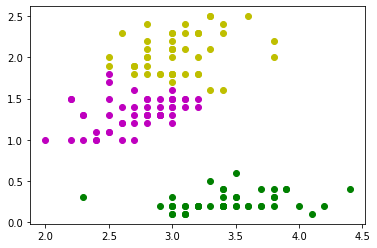

In [656]:
main();